In [2]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')

from pathlib import Path
from analysis import collection, analysis, plot
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress, tukey_hsd
import scipy as sp

image_path = Path("/Users/spencer/phd/phd/images/basic_results/decoder_vs_performance")

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

%matplotlib inline

## For each target: 
- compute average correlation between (normalized) task-space decoder axes and target vector
- now you have 12 correlations for each subject
- for each target, across subjects, how well does that decoder correlation predict performance per target?
- plot = subjects' total performance (hits) per target vs. decoder corr for that target -- plot all targets together? (color-coded?)

### how are the offsets and variance calculated?

offsets -- extract quiescent periods before movement cue is given, filter these and take the mean. this is then subtracted from the "live" signal as a shift.

variance -- this is computed per channel from the calibration bars dataset, divided per channel as a whitening

# get reward

In [3]:
import pandas as pd
reward_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = reward_df.groupby(level=["subject"]).mean()["reward"]**-1
mean_rewards.shape

(46,)

## get decoders

In [4]:
subjects = analysis.load_subjects()
decoders = {}
for s in subjects:
    decoders[s.name] = s.decoder[-2:,:]

decoder_list = [s.decoder[-2:,:] for s in subjects]

# plot decoder directions in task space

In [5]:
def plot_decoder_arrows(decoder, ax, **kwargs):
    plot.plot_targets(ax,color="r")
    # plot x and y components of the decoder
    for col in decoder[-2:,:].T:
        ax.arrow(0,0,col[0],col[1],head_width=.01,**kwargs)

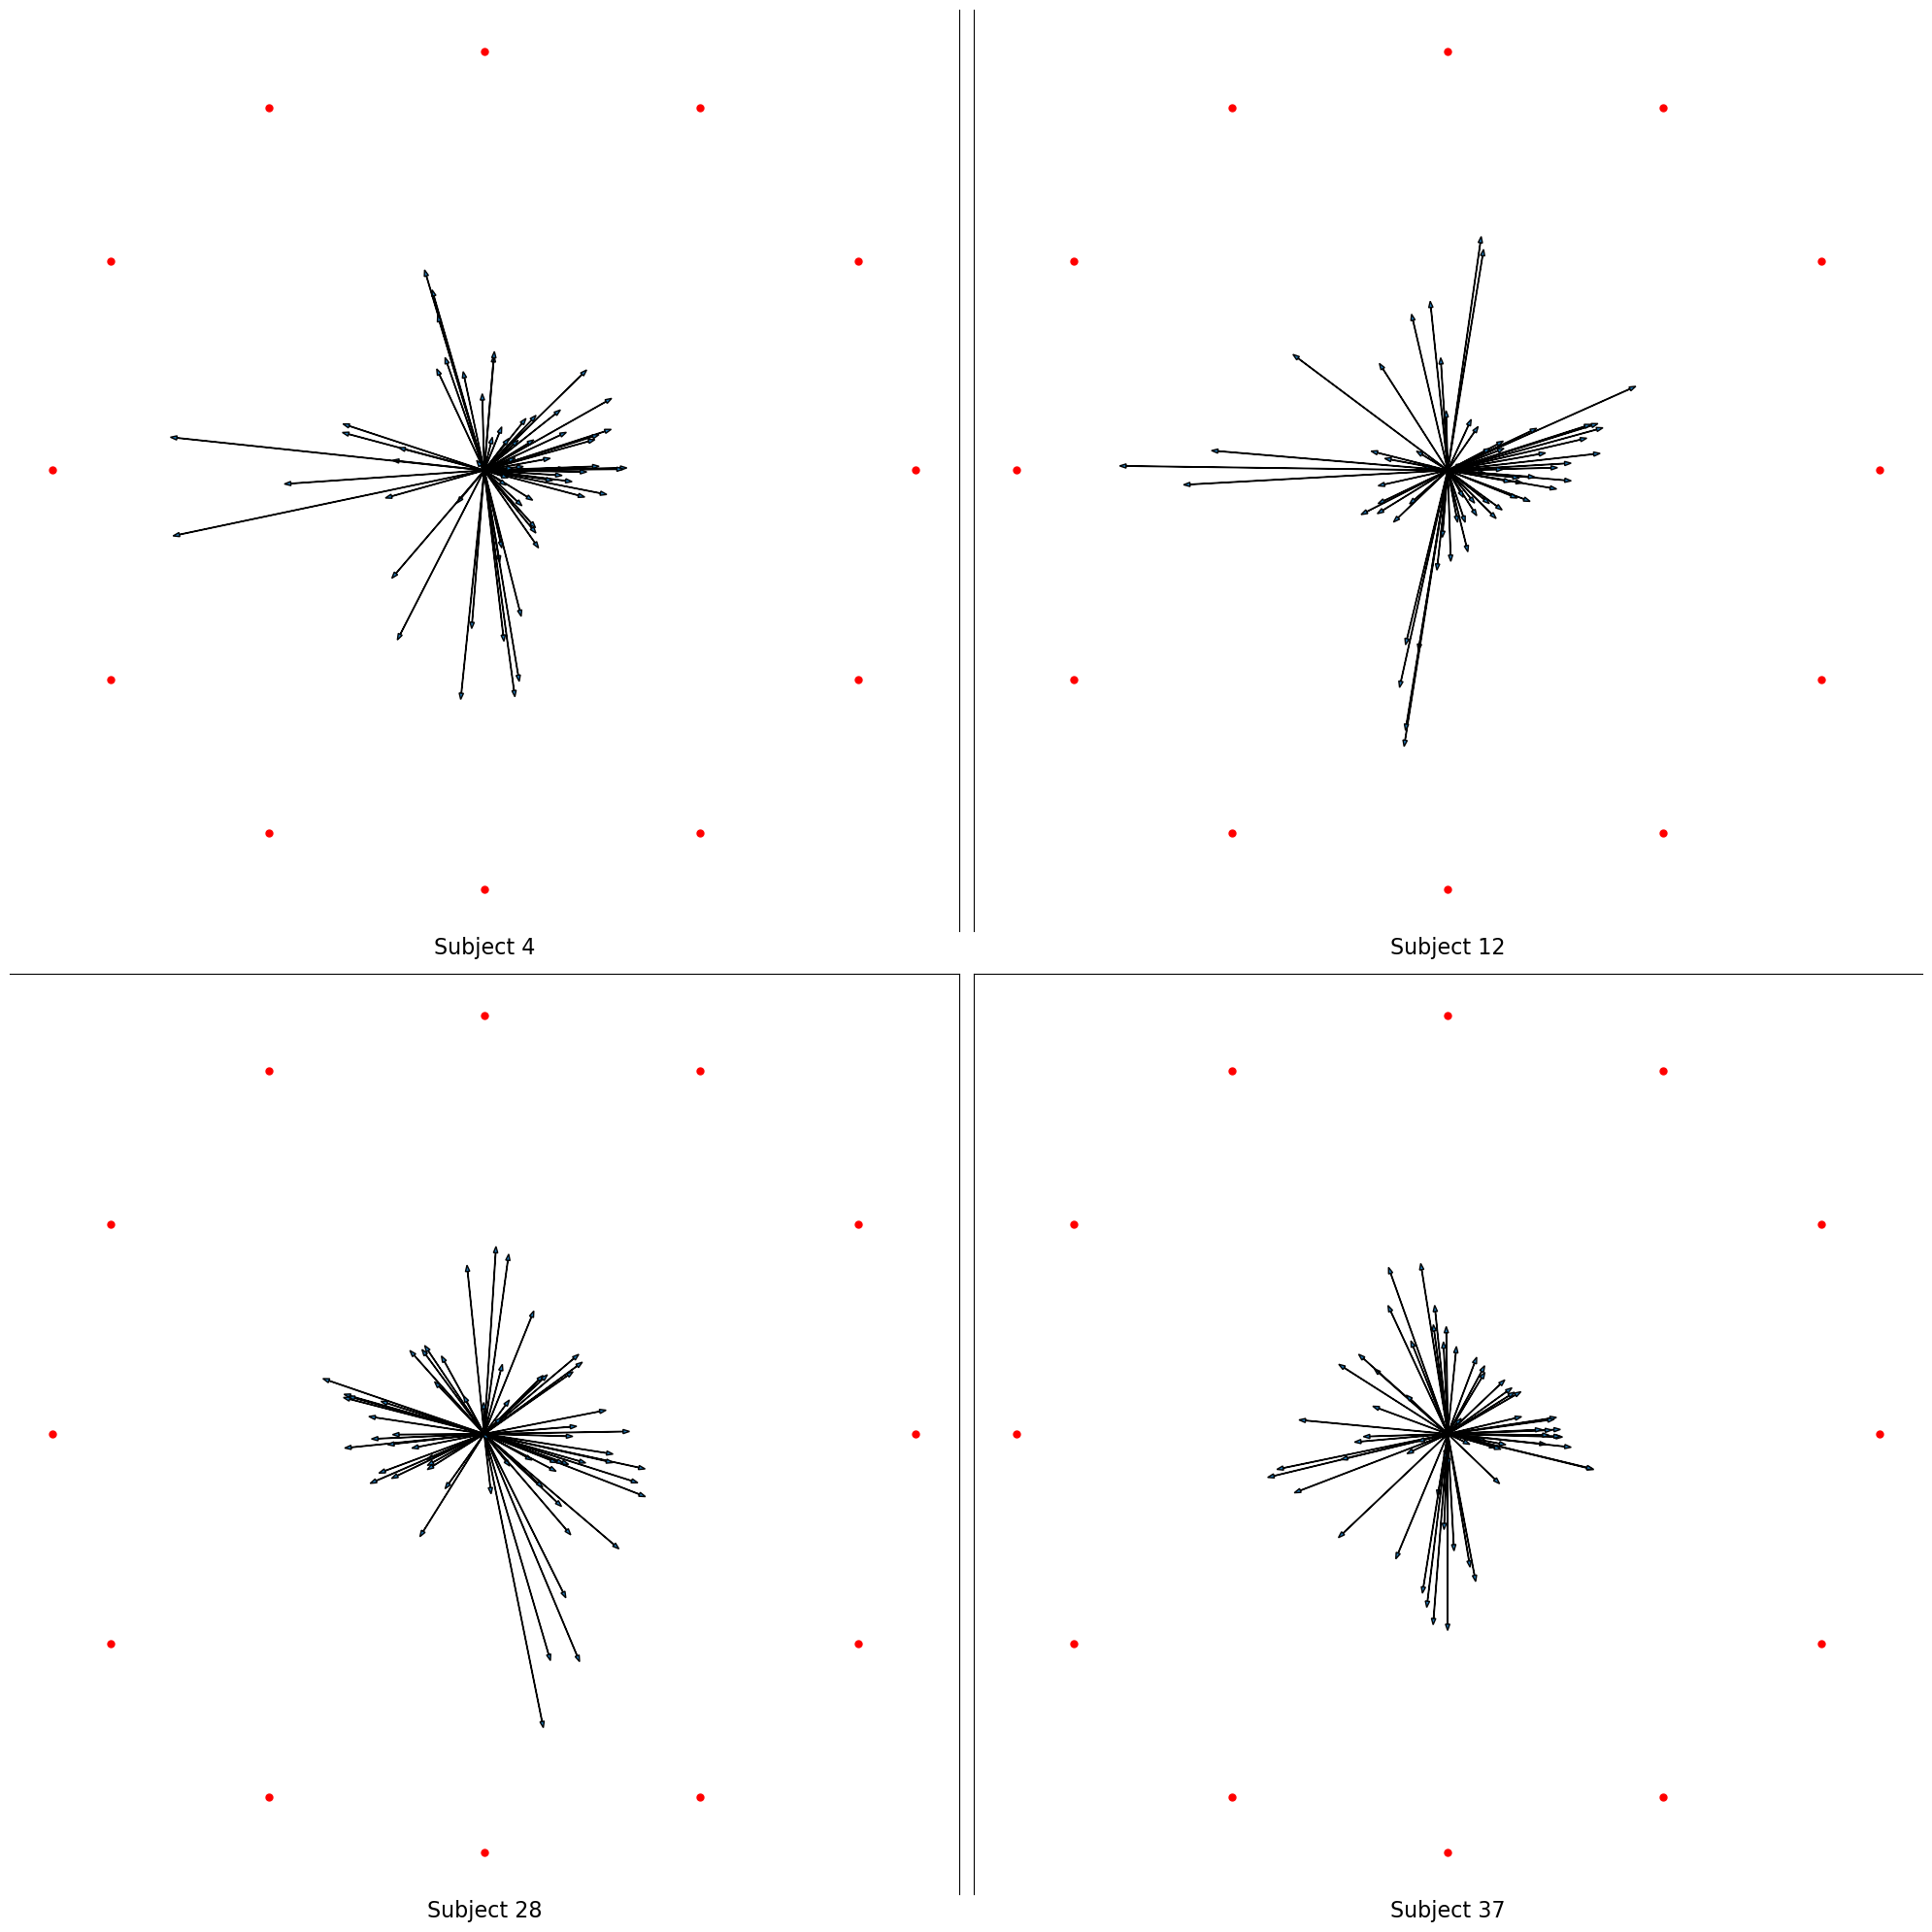

In [6]:
decoder_arrow_fig, axes = plt.subplots(2,2,figsize=(20,20))
example_subjects = np.array([[4, 12], [28, 37]])
subject_names = [s.name for s in subjects]
plot_decoder_arrows(decoders[subject_names[example_subjects[0][0]]], axes[0][0])
plot_decoder_arrows(decoders[subject_names[example_subjects[0][1]]], axes[0][1])
plot_decoder_arrows(decoders[subject_names[example_subjects[1][0]]], axes[1][0])
plot_decoder_arrows(decoders[subject_names[example_subjects[1][1]]], axes[1][1])
for i, (sub, ax) in enumerate(zip(example_subjects.ravel(),axes.ravel())):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"Subject {sub}")
    # ax.axis("off")
    if i == 0:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    elif i == 1:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(True)
    elif i == 2:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    elif i == 3:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(True)

decoder_arrow_fig.tight_layout()

In [5]:
plot.save_figure(decoder_arrow_fig, "decoder_arrows", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/decoder_vs_performance/decoder_arrows.pdf


# plot mean decoder over subjects

Text(0, 0.5, '$y$ coordinate')

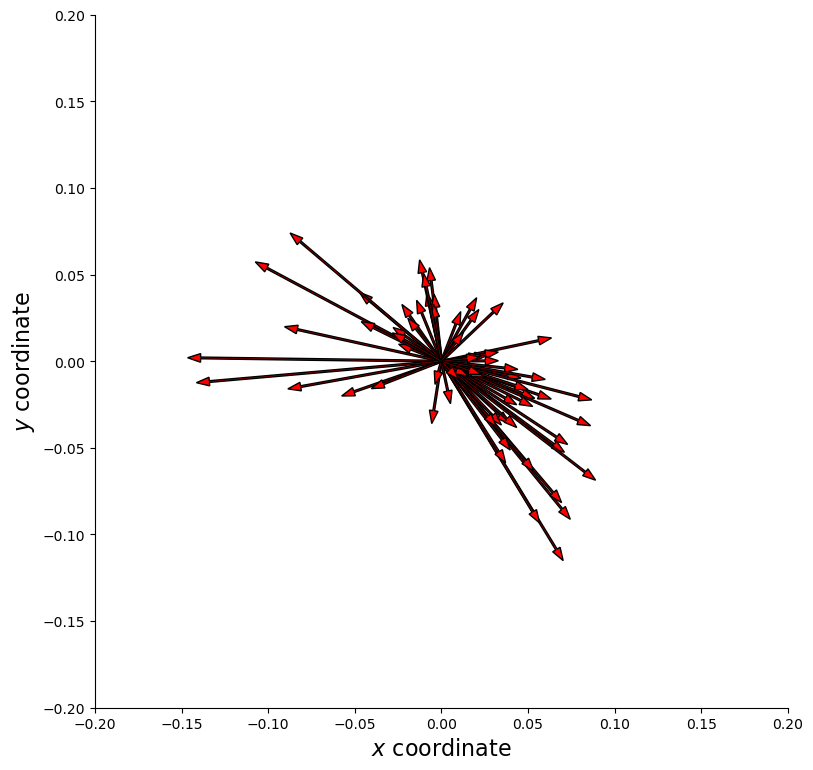

In [28]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
for col in np.array(decoder_list).mean(axis=0).T:
    ax.arrow(0,0,col[0],col[1],head_width=.005,facecolor="r")
ax.set_xlim([-0.2,0.2])
ax.set_ylim([-0.2,0.2])
ax.set_aspect("equal")
ax.set_xlabel("$x$ coordinate")
ax.set_ylabel("$y$ coordinate")

In [29]:
plot.save_figure(fig,"mean_decoder",image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/decoder_vs_performance/mean_decoder.pdf


# decoder cosine vs. reward

In [7]:
def compute_decoder_cosine(decoder):
        assert decoder.shape == (2,64)
        return distance.cosine(decoder[0],decoder[1])

def compute_decoder_cosine_similarity(decoder):
    # cos = 1 - abs(dot(a,b) / (norm(a)*norm(b)))
    # orthogonal --> 90deg, dot=0 --> 1 
    # parallel --> 0deg, dot=1 --> 0
    x = decoder[-2,:]
    y = decoder[-1,:]
    return (np.dot(x,y) / (np.linalg.norm(x)*np.linalg.norm(y)))

z = np.zeros(shape=(2,64))
z[0,12] = 1
z[1,12] = -0.5
compute_decoder_cosine(z), compute_decoder_cosine_similarity(z)

(2.0, -1.0)

NameError: name 'hit_count' is not defined

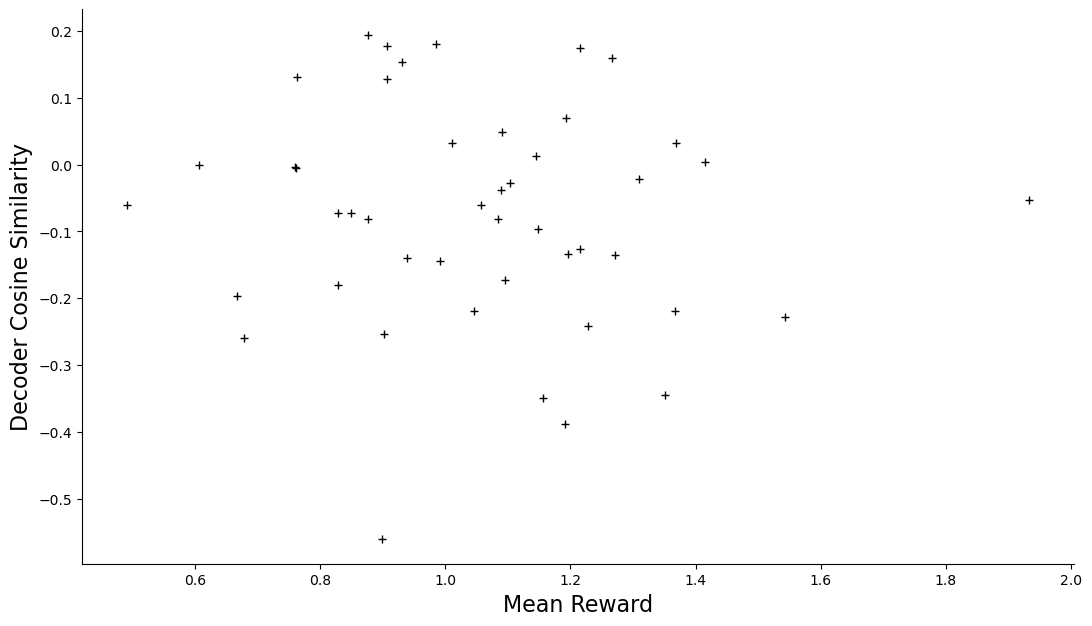

In [8]:
decoder_cosine_fig = plt.figure(figsize=(16*0.8,9*0.8))

decoder_cosines = [compute_decoder_cosine_similarity(d) for d in decoder_list]

plt.plot(mean_rewards,decoder_cosines,"k+")
plt.xlabel("Mean Reward")
plt.ylabel("Decoder Cosine Similarity")
res = analysis.linear_fit(hit_count, decoder_cosines)
x = analysis.linspace(mean_rewards)
# plot.plot_linear_fit(x,res,ax=plt.gca())
plt.gca().plot(x, res.intercept + res.slope*x,"--", color="tab:red", label=f"Linear Fit, $R^2$={plot.format_positional(res.rvalue**2)}, $p$={plot.format_scientific(res.pvalue)}")
plt.legend()

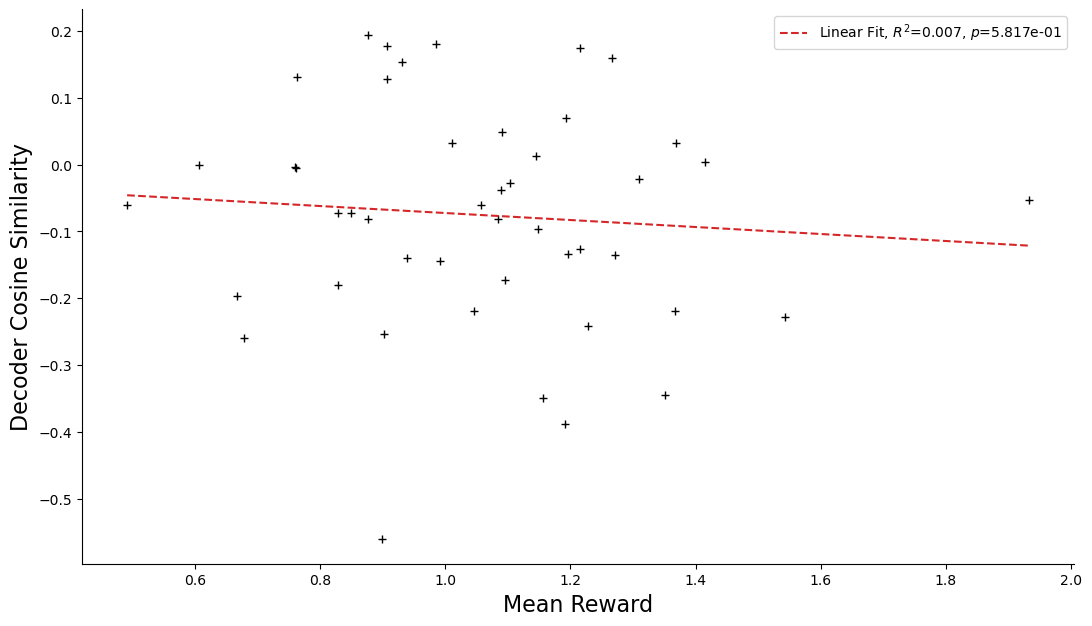

In [9]:
decoder_cosine_fig = plt.figure(figsize=(16*0.8,9*0.8))

decoder_cosines = [compute_decoder_cosine_similarity(d) for d in decoder_list]

plt.plot(mean_rewards,decoder_cosines,"k+")
plt.xlabel("Mean Reward")
plt.ylabel("Decoder Cosine Similarity")
res = analysis.linear_fit(mean_rewards, decoder_cosines)
x = analysis.linspace(mean_rewards)
# plot.plot_linear_fit(x,res,ax=plt.gca())
plt.gca().plot(x, res.intercept + res.slope*x,"--", color="tab:red", label=f"Linear Fit, $R^2$={plot.format_positional(res.rvalue**2)}, $p$={plot.format_scientific(res.pvalue)}")
plt.legend()

In [9]:
plot.save_figure(decoder_cosine_fig, "decoder_cosine_vs_reward", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/decoder_vs_performance/decoder_cosine_vs_reward.pdf


# compute decoder-target mean cosine distance per target

In [10]:


def compute_decoder_target_cosine(decoder, target_vector):
        # compute the cosine distance between target direction and decoder direction 
        # decoder : 64x2 64 - x,y 
        # target_vector: 2x1 (x,y)
        dotprod = np.dot(decoder,target_vector).reshape(64,1) # 64
        norm_target = np.linalg.norm(target_vector) # 1
        norm_decoder_directions = np.linalg.norm(decoder, axis=1).reshape(64,1) # 64
        # cos = 1 - abs(dot(a,b) / (norm(a)*norm(b)))
        # orthogonal --> 90deg, dot=0 --> 1 
        # parallel --> 0deg, dot=1 --> 0

        return np.divide(dotprod, (norm_target*norm_decoder_directions))

def compute_decoder_target_projection(decoder, target_vector):
        # compute the cosine distance between target direction and decoder direction 
        # decoder : 64x2 64 - x,y 
        # target_vector: 2x1 (x,y)
        return np.dot(decoder,target_vector).reshape(64,1) # 64

def mean_decoder_norm(decoder):
        assert decoder.shape[0] == 2
        n = np.linalg.norm(decoder,axis=0)
        return n.mean()

def generate_target_coords():
    coords = {}
    for i, angle in enumerate(collection.generate_target_angles()):
        coords[i+1] = [np.cos(angle), np.sin(angle)]
    return coords

In [11]:
mean_cosine_vec = np.empty((len(subjects),12))
mean_projection_vec = np.empty((len(subjects),12))
# for each subject
for subject_number, s in enumerate(subjects):
    # get the decoder
    decoder = s.decoder[-2:,:].T # 64x2
    # for each target vector
    for target_number, target_vector in generate_target_coords().items():
        cosine = compute_decoder_target_cosine(decoder, target_vector)
        projection = compute_decoder_target_projection(decoder, target_vector) # / mean_decoder_norm(decoder.T)
        # compute the mean of the cosine distances
        mean_cosine_vec[subject_number][target_number-1] = np.mean(cosine)
        mean_projection_vec[subject_number][target_number-1] = np.mean(projection)

## does mean decoder-target alignment correlate with performance?

In [12]:
# fig, ax = plt.subplots(1,1,figsize=(20,15))

# for target_idx, subject_projection_means in enumerate(mean_projection_vec.T[:4]):
#     x = target_idx*np.ones(subject_projection_means.shape[0])
#     ax.plot(x, subject_projection_means[:], "ko", alpha=0.2, markersize=10)
#     ax.errorbar(x[0], np.mean(subject_projection_means[:]), np.std(subject_projection_means[:]), color="r", capsize=5)
#     ax.plot(x[0], np.mean(subject_projection_means[:]),"ro", markersize=10)
# # ax.set_ylim([-0.25,0.25])
# ax.set_xlabel("Target Location")
# ax.set_ylabel("Mean Decoder-Target Dot Product per Subject")
# # _ = ax.set_xticks(range(12), labels=[str(collection.compute_target_vec_from_number(tn)) for tn in range(1,13)], rotation=45)


In [13]:
# fig, ax = plt.subplots(1,1,figsize=(20,15))

# for target_idx, subject_cosine_means in enumerate(mean_cosine_vec.T[:4]):
#     x = target_idx*np.ones(subject_cosine_means.shape[0])
#     ax.plot(x, subject_cosine_means[:], "ko", alpha=0.2, markersize=10)
#     ax.errorbar(x[0], np.mean(subject_cosine_means[:]), np.std(subject_cosine_means[:]), color="r", capsize=5)
#     ax.plot(x[0], np.mean(subject_cosine_means[:]),"ro", markersize=10)
# # ax.set_ylim([-1,1])
# ax.set_xlabel("Target Location")
# ax.set_ylabel("Mean Decoder-Target Cosine Distance per Subject")
# # _ = ax.set_xticks(range(12), labels=[str(collection.compute_target_vec_from_number(tn)) for tn in range(1,13)], rotation=45)

LinregressResult(slope=0.00598194042085353, intercept=-0.03006397592764356, rvalue=0.049556189310788104, pvalue=0.7436242930596604, stderr=0.018175397263664857, intercept_stderr=0.01976571977925399)


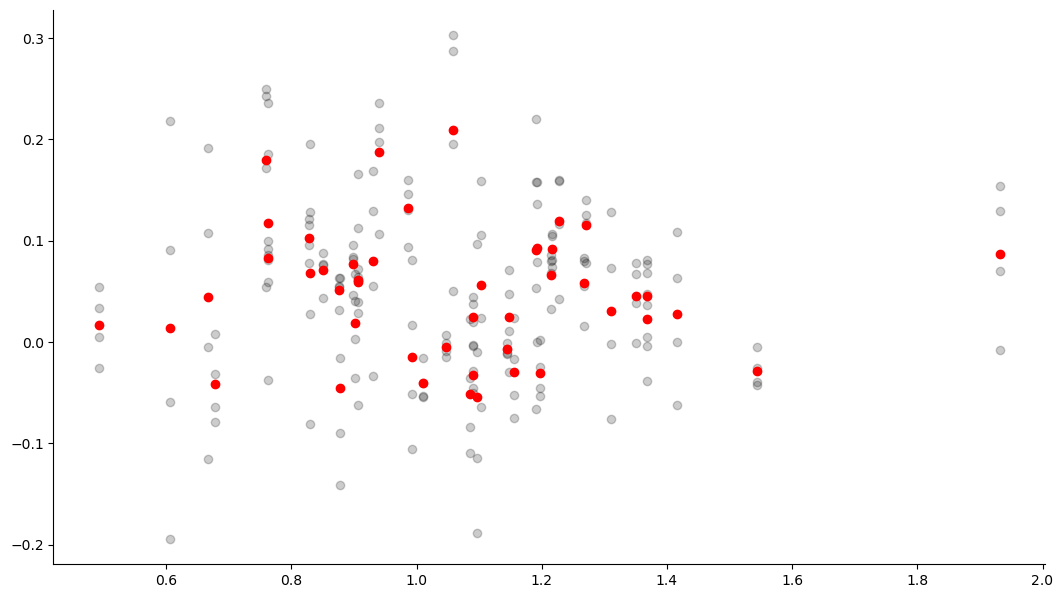

In [14]:
for i in range(11,7,-1):
    plt.plot(mean_rewards, mean_cosine_vec[:,i],"ko",alpha=0.2)
plt.plot(mean_rewards, mean_cosine_vec[:,-4:].mean(axis=1),"ro")
res = analysis.linear_fit(mean_rewards,mean_cosine_vec[:,:-4].mean(axis=1))
print(res)

In [15]:
# fig.savefig(image_path / "analysis/decoder_target_cosine_vs_reward.pdf", dpi=300, format="pdf")

# hit counts per target -- is there a bias towards certain targets?

### stats pairwise between target results to look for trends per target?

(46, 12)


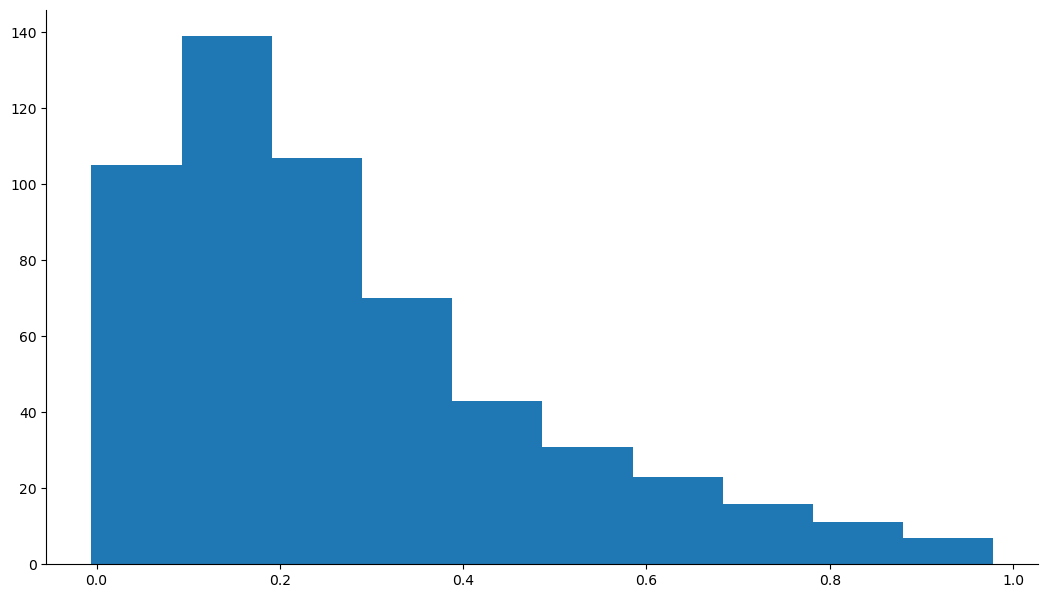

In [28]:
hit_count_vec = np.zeros(shape=(len(subjects),12))
for subject_idx, subject in enumerate(subjects):
    sessions  = subject.tasks["center_hold"].sorted_sessions()
    # for every trial, add up hits for each target
    trial_count = 0
    for sesh in sessions:
        trials = sesh.sorted_trials()
        for trial in trials:
            trial_count += 1
            if trial.outcome == "Hit":
                # subject, target_index
                hit_count_vec[subject_idx][trial.target_number-1] += 1
    hit_count_vec[subject_idx] = ((trial_count/12) - hit_count_vec[subject_idx])/(trial_count/12)

plt.hist(hit_count_vec.reshape(-1))
print(hit_count_vec.shape)

result = sp.stats.tukey_hsd(*hit_count_vec.T)

Text(995.8377777777777, 0.5, '$p$ value')

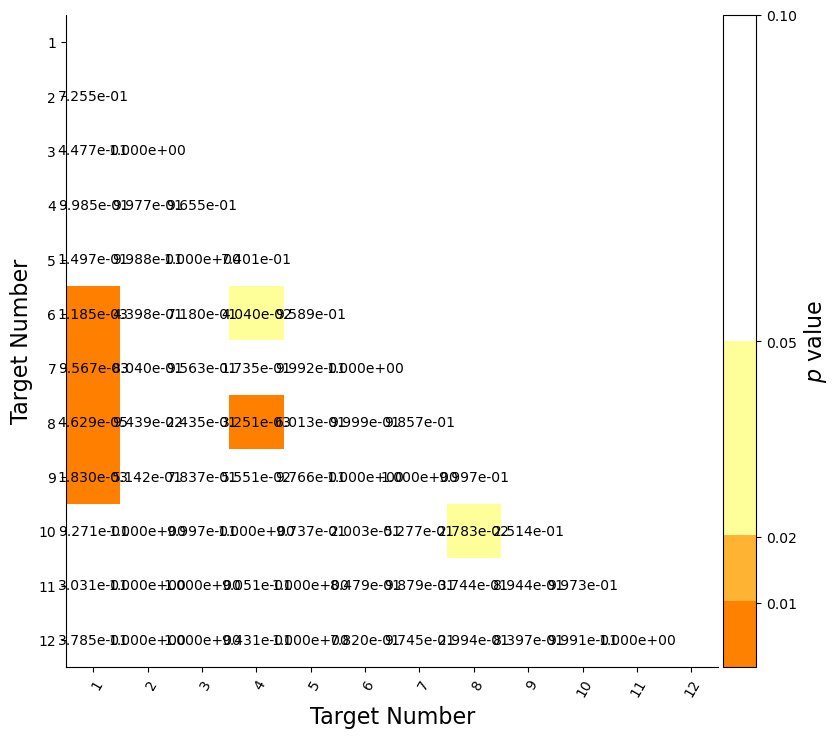

In [31]:
pvalue_fig, axes = plot.annotated_heatmap(result.pvalue,list(range(1,13)),list(range(1,13)))
axes[0].set_xlabel("Target Number")
axes[0].set_ylabel("Target Number")
axes[1].set_ylabel("$p$ value")

In [21]:
plot.save_figure(pvalue_fig, "target_hit_pvalues",image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/decoder_vs_performance/target_hit_pvalues.pdf


"The null hypothesis is that the distributions underlying the samples all have the same mean."

"For each pair, the p-value is the probability under the null hypothesis..."

In [33]:
result.pvalue[np.tril_indices(12)] = 100
significant_target_pairs = np.stack(np.where(result.pvalue < 0.05))+1
print([(t1,t2) for t1,t2 in significant_target_pairs.T])
print([plot.format_scientific(x) for x in result.pvalue[np.where(result.pvalue < 0.05)]])

[]
[]


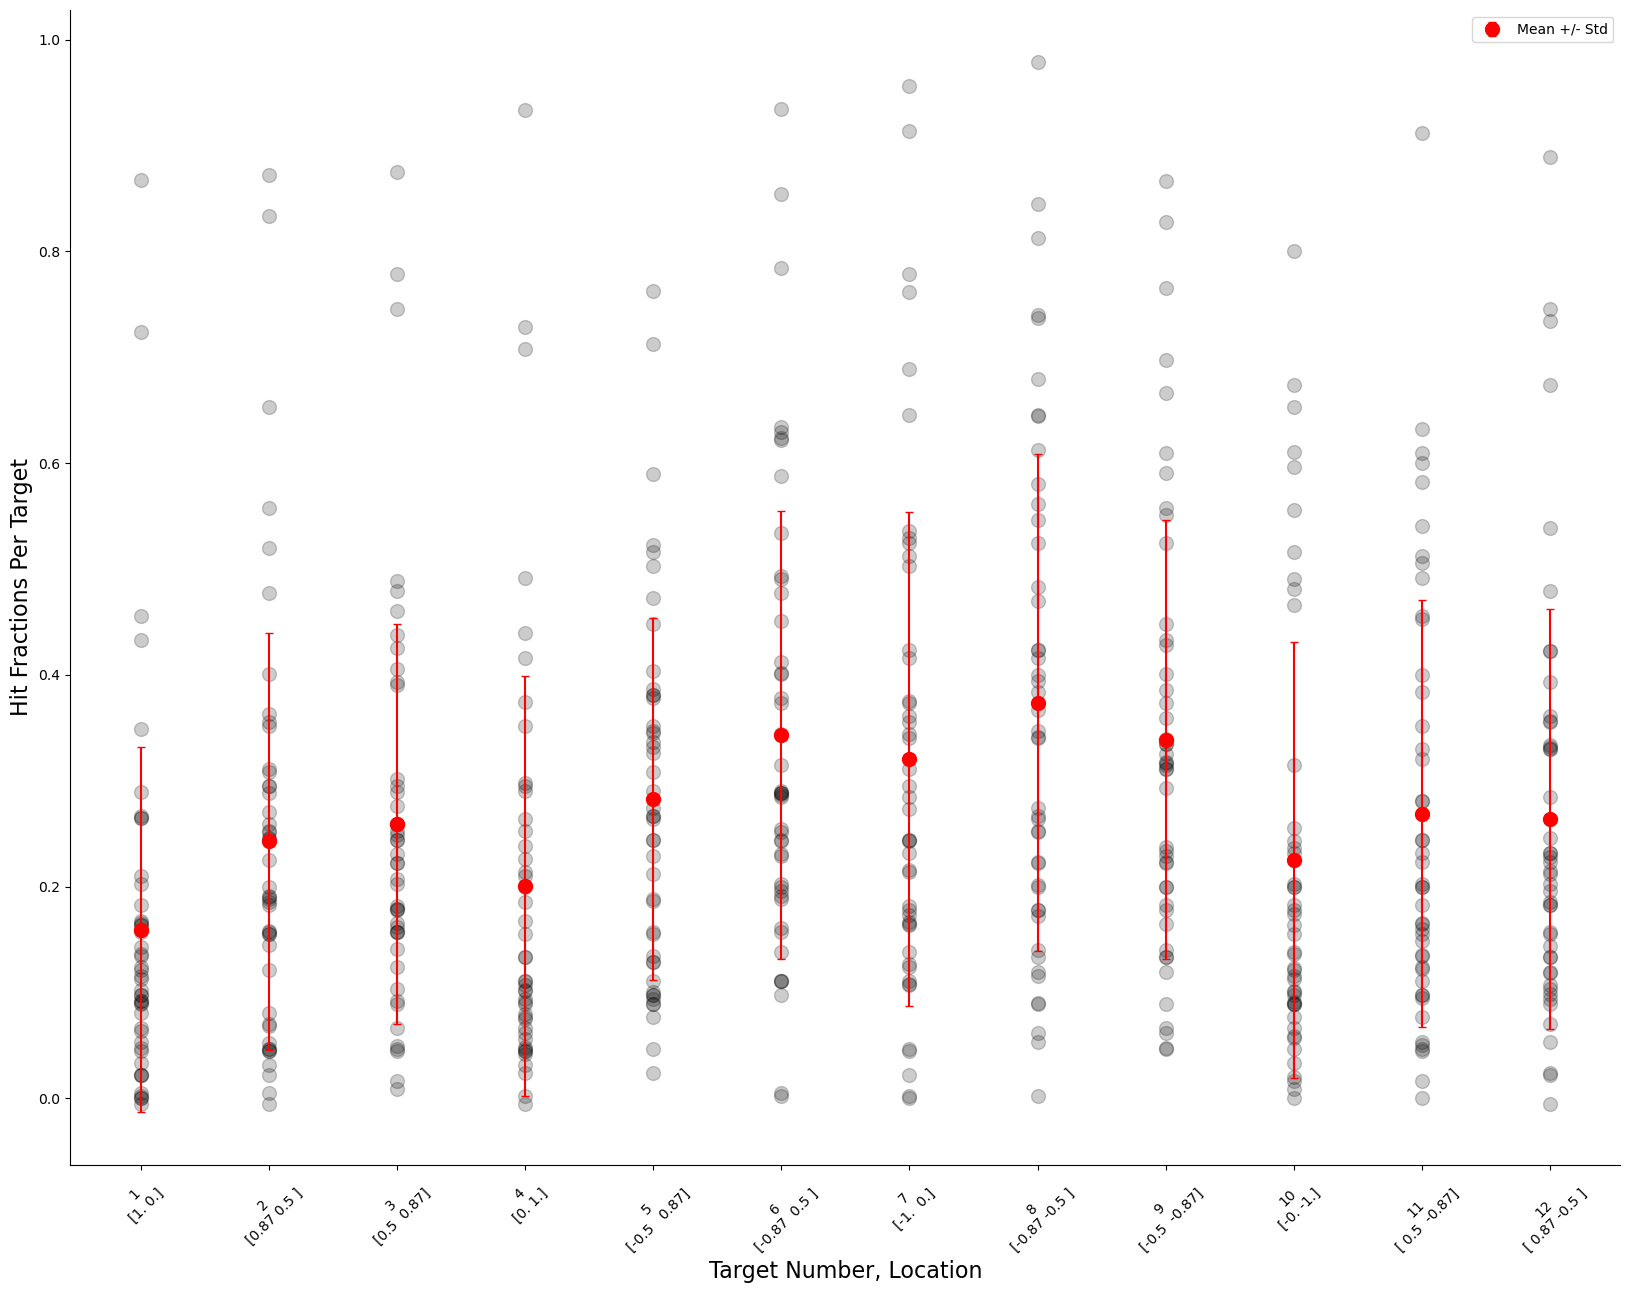

In [32]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
for target_idx, target_hc in enumerate(hit_count_vec.T):
    ax.plot(np.ones(len(target_hc))*(target_idx), target_hc, 'ko', alpha=0.2, markersize=10)

x = list(range(12))
means = np.mean(hit_count_vec, axis=0)
stds = np.std(hit_count_vec, axis=0)
ax.errorbar(x, means, stds, linestyle='None', marker='o', markersize=10, capsize=3, label="Mean +/- Std", color="red")

ax.set_xticks(x, labels=[f"{xx+1}\n{str(collection.compute_target_vec_from_number(xx+1))}" for xx in x], rotation=45)
ax.set_ylabel("Hit Fractions Per Target") 
# ax.set_ylim([-1,1])
ax.set_xlabel("Target Number, Location")
ax.legend()

In [26]:
plot.save_figure(fig, "hits_over_targets", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/decoder_vs_performance/hits_over_targets.pdf


In [27]:
from matplotlib.markers import MarkerStyle
def plot_weighted_targets(ax, weights):
    m = MarkerStyle("o", fillstyle="none")
    theta = np.linspace(0, 2 * np.pi, 13)
    for t, w in zip(theta, weights):
        ax.plot(
            np.cos(t),
            np.sin(t),
            marker=m,
            markersize=w,
            color="grey",
        )

Text(0, 0.5, 'Screen Coordinate $y$')

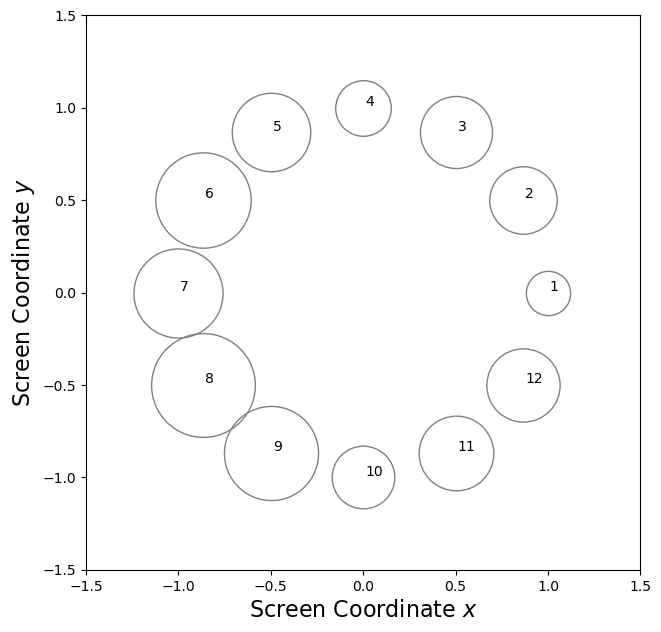

In [28]:
# array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return array[idx]

# target number is counted from [1,0] counterclockwise, in order of increasing theta

target_fig = plt.figure(figsize=(16*0.8,9*0.8))

trial = subjects[0].tasks["center_hold"].sorted_sessions()[0].sorted_trials()[10]

plot_weighted_targets(plt.gca(), np.mean(hit_count_vec, axis=0)*200)

i = 1
for a in collection.generate_target_angles():
    plt.annotate(i, (np.cos(a)+0.01, np.sin(a)+0.01))
    i+=1

# theta = collection.compute_theta(collection.compute_target_vec_from_number(11))
# plt.plot(np.cos(theta), np.sin(theta), "ro")

# print(trial.target_coords, trial.target_number)
# print(collection.compute_target_number_from_vec(trial.target_coords))

# theta2 = collection.compute_theta(trial.target_coords)
# plt.plot(np.cos(theta2), np.sin(theta2), "bo")

# theta3 = collection.compute_theta(collection.compute_target_vec_from_number(collection.compute_target_number_from_vec(trial.target_coords)))
# plt.plot(np.cos(theta3), np.sin(theta3), "go")

plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.gca().set_aspect("equal")
plt.xlabel("Screen Coordinate $x$")
plt.ylabel("Screen Coordinate $y$")

In [29]:
plot.save_figure(target_fig, "target_means", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/decoder_vs_performance/target_means.pdf


In [30]:
# # plot just the means

# fig, ax = plt.subplots(1,1,figsize=(15,15))

# hc_means = np.mean(hit_count_vec, axis=0)
# mc_means = np.mean(mean_projection_vec, axis=0)
# for x,y in zip(hc_means, mc_means):
#     ax.plot(x,y,"ko")

# # result = linregress(hc_means, mc_means)
# # x = np.linspace(20,50,100)
# # ax.plot(x, result.intercept + result.slope*x,"r--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2,5)}")
# ax.set_xlabel("Per Target Hit Count, Mean over Subjects")
# ax.set_ylabel("Mean Decoder-Target Dot Product, Mean over Subjects")
# # ax.set_ylim([-1,1])
# ax.legend()

In [31]:
# # plot just the means

# fig, ax = plt.subplots(1,1,figsize=(15,15))

# hc_means = np.mean(hit_count_vec, axis=0)
# mc_means = np.mean(mean_cosine_vec, axis=0)
# for x,y in zip(hc_means, mc_means):
#     ax.plot(x,y,"ko")

# # result = linregress(hc_means, mc_means)
# # x = np.linspace(20,50,100)
# # ax.plot(x, result.intercept + result.slope*x,"r--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2,5)}")
# ax.set_xlabel("Per Target Hit Count, Mean over Subjects")
# ax.set_ylabel("Mean Decoder-Target Cosine Distance, Mean over Subjects")
# # ax.set_ylim([-1,1])
# ax.legend()

In [32]:
# fig.savefig(image_path / "analysis/decoder_target_cosine_vs_hits_subject_mean.pdf", dpi=300, format="pdf")

In [33]:
# fig, ax = plt.subplots(1,1,figsize=(15,15))

# for x,y in zip(hit_count_vec.ravel(), mean_projection_vec.ravel()):
#     ax.plot(x,y,"ko",alpha=0.2)

# result = linregress(hit_count_vec.ravel(), mean_projection_vec.ravel())
# x = np.linspace(0,50,100)
# ax.plot(x, result.intercept + result.slope*x,"r--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2,5)}")
# ax.set_xlabel("Per Target Hit Count")
# ax.set_ylabel("Mean Decoder-Target Cosine Distance")
# ax.set_ylim([-1,1])
# ax.legend()

In [34]:
# fig, ax = plt.subplots(1,1,figsize=(15,15))

# for x,y in zip(hit_count_vec.ravel(), mean_cosine_vec.ravel()):
#     ax.plot(x,y,"ko",alpha=0.2)

# result = linregress(hit_count_vec.ravel(), mean_cosine_vec.ravel())
# x = np.linspace(0,50,100)
# ax.plot(x, result.intercept + result.slope*x,"r--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2,5)}")
# ax.set_xlabel("Per Target Hit Count")
# ax.set_ylabel("Mean Decoder-Target Cosine Distance")
# ax.set_ylim([-1,1])
# ax.legend()

In [35]:
# fig.savefig(image_path / "analysis/decoder_target_cosine_vs_hits.pdf", dpi=300, format="pdf")

# Are decoders normal?

generate uniform random samples in trajectory space
pass through the decoder -- do normality test on this

### uniform in $R^{64}$ --> ??? in $R^2$

In [11]:
def test_decoder_for_normality(subject_idx):
    decoder = subjects[subject_idx].decoder[-2:,:].T
    X = np.random.uniform(low=-1.,high=1.,size=(10000,64))
    T = X @ decoder
    return sp.stats.normaltest(T).pvalue

pvalues = []
for i in range(46):
    pvalues.append(test_decoder_for_normality(i))

In [12]:
pvalues = np.array(pvalues)

[1.62226489e-05 5.50122838e-01]
[0.94451059 0.37380992]


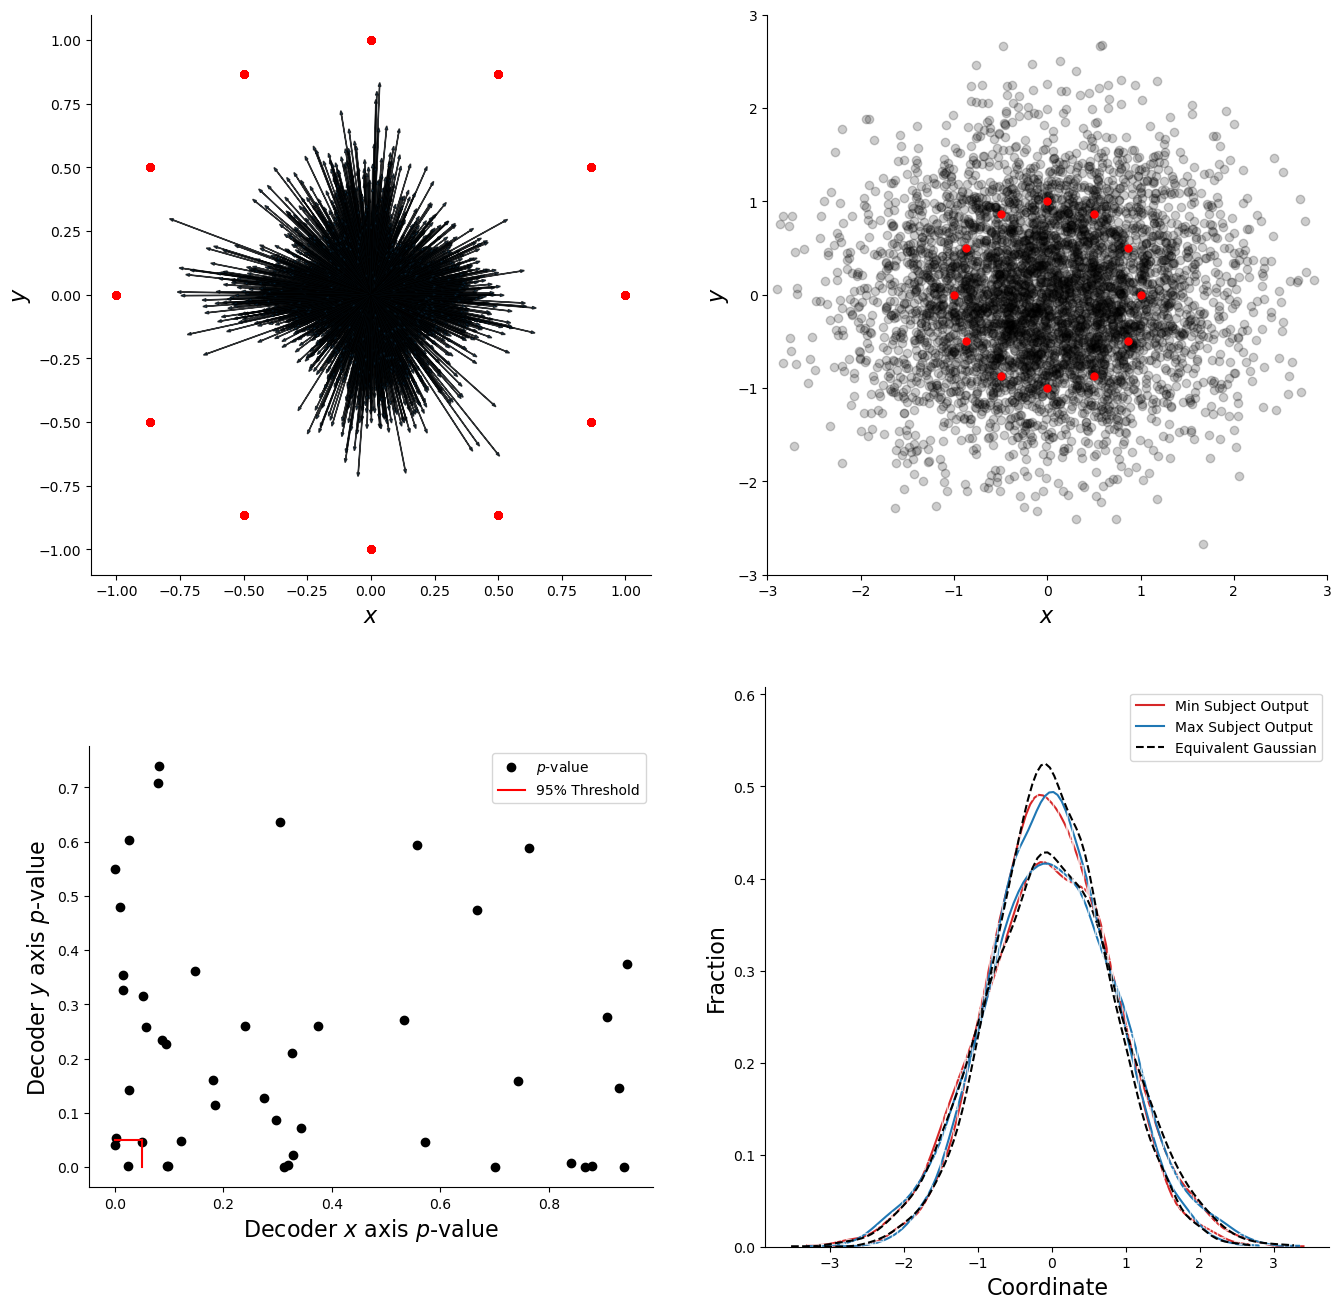

In [16]:
normal_decoder_fig, axes = plt.subplots(2,2,figsize=(16,16))
axes = axes.ravel()

ax.set_aspect('equal')
for d in decoder_list:
    plot_decoder_arrows(d,axes[0],alpha=0.8)
axes[0].set_xlabel("$x$")
axes[0].set_ylabel("$y$")

####
    
for ax in axes[:-1]:
    ax.set_aspect("equal")

X = np.random.uniform(low=-1.,high=1.,size=(5000,64))
min_p = np.argmin(np.min(pvalues,axis=1))
print(pvalues[min_p])
decoder = subjects[min_p].decoder[-2:,:].T
T = X @ decoder

axes[1].plot(T[:,0],T[:,1],"ko",alpha=0.2)
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("$y$")
axes[1].set_xlim([-3,3])
axes[1].set_ylim([-3,3])
plot.plot_targets(axes[1],color="r")

n, x, _ = axes[3].hist(T[:,0],color="white",alpha=0.7,bins=100,histtype=u'step', density=True)
density = sp.stats.gaussian_kde(T[:,0])
axes[3].plot(x, density(x),"-",color="tab:red")
n, x, _ = axes[3].hist(T[:,1],color="white",alpha=0.7,bins=100,histtype=u'step', density=True)
density = sp.stats.gaussian_kde(T[:,1])
axes[3].plot(x, density(x),"-",color="tab:red",label="Min Subject Output")

max_p = np.argmax(np.max(pvalues,axis=1))
print(pvalues[max_p])
decoder = subjects[max_p].decoder[-2:,:].T
T = X @ decoder

n, x, _ = axes[3].hist(T[:,0],color="white",alpha=0.7,bins=100,histtype=u'step', density=True)
density = sp.stats.gaussian_kde(T[:,0])
axes[3].plot(x, density(x),"-",color="tab:blue")

n, x, _ = axes[3].hist(T[:,1],color="white",alpha=0.7,bins=100,histtype=u'step', density=True)
density = sp.stats.gaussian_kde(T[:,1])
axes[3].plot(x, density(x),"-",color="tab:blue",label="Max Subject Output")

Xs = np.random.normal(loc=T[:,0].mean(),scale=T[:,0].std(),size=5000)
n, x, _ = axes[3].hist(Xs,color="white",alpha=0.7,bins=100,histtype=u'step', density=True)
density = sp.stats.gaussian_kde(Xs)
axes[3].plot(x, density(x),"--",color="k")

Xs = np.random.normal(loc=T[:,1].mean(),scale=T[:,1].std(),size=5000)
n, x, _ = axes[3].hist(Xs,color="white",alpha=0.7,bins=100,histtype=u'step', density=True)
density = sp.stats.gaussian_kde(Xs)
axes[3].plot(x, density(x),"--",color="k",label="Equivalent Gaussian")
axes[3].legend()

axes[3].set_ylabel("Fraction")
axes[3].set_xlabel("Coordinate")

h1, = axes[2].plot(pvalues.T[0],pvalues.T[1],"ko")
axes[2].plot([0.05,0.05],[0,0.05],"r-")
h2, = axes[2].plot([0,0.05],[0.05,0.05],"r-")
axes[2].set_xlabel("Decoder $x$ axis $p$-value")
axes[2].set_ylabel("Decoder $y$ axis $p$-value")
axes[2].legend([h1,h2],["$p$-value","95% Threshold"])


In [17]:
plot.save_figure(normal_decoder_fig, "decoder_normality_test", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/decoder_vs_performance/decoder_normality_test.pdf


## are decoders more likely to be in the task or null space?

if i sample the EMG space uniformly, are subjects more likely to end up in the task space or the null space?

In [14]:
subject_idx = 0
decoder = subjects[subject_idx].decoder[-2:,:]
X = np.random.uniform(low=-1.,high=1.,size=(10000,64))

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
model = BayesianGaussianMixture(n_components=12,
                                weight_concentration_prior_type='dirichlet_process',
                                weight_concentration_prior=1.0E-8,
                                max_iter=300,
                                n_init=2,
                                warm_start=True,
                                random_state=0,
                                )
model.fit(X)
task, null = analysis.compute_subspaces(decoder)
ratios = [analysis.mean_quadratic_form(cov,task) / analysis.mean_quadratic_form(cov,null) for cov in model.covariances_]
print(ratios)

[array([1.23940007]), array([1.03096771]), array([1.01666161]), array([1.00246668]), array([0.93551656]), array([1.01161428]), array([1.01647892]), array([0.81572028]), array([0.85012662]), array([1.03989999]), array([1.01430719]), array([0.95076418])]


In [16]:
np.mean(ratios)

0.9936603413496953

In [22]:
# for i in range(10):
#     decoder = subjects[i].decoder[-2:,:]
#     plt.figure()
#     plt.hist(decoder[0])
#     plt.hist(decoder[1])

# make a radar plot

In [91]:
# import numpy as np

# import matplotlib.pyplot as plt
# from matplotlib.patches import Circle, RegularPolygon
# from matplotlib.path import Path
# from matplotlib.projections.polar import PolarAxes
# from matplotlib.projections import register_projection
# from matplotlib.spines import Spine
# from matplotlib.transforms import Affine2D


# def radar_factory(num_vars, frame='circle'):
#     """Create a radar chart with `num_vars` axes.

#     This function creates a RadarAxes projection and registers it.

#     Parameters
#     ----------
#     num_vars : int
#         Number of variables for radar chart.
#     frame : {'circle' | 'polygon'}
#         Shape of frame surrounding axes.

#     """
#     # calculate evenly-spaced axis angles
#     theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

#     class RadarAxes(PolarAxes):

#         name = 'radar'

#         def __init__(self, *args, **kwargs):
#             super().__init__(*args, **kwargs)
#             # rotate plot such that the first axis is at the top
#             self.set_theta_zero_location('N')

#         def fill(self, *args, closed=True, **kwargs):
#             """Override fill so that line is closed by default"""
#             return super().fill(closed=closed, *args, **kwargs)

#         def plot(self, *args, **kwargs):
#             """Override plot so that line is closed by default"""
#             lines = super().plot(*args, **kwargs)
#             for line in lines:
#                 self._close_line(line)

#         def _close_line(self, line):
#             x, y = line.get_data()
#             # FIXME: markers at x[0], y[0] get doubled-up
#             if x[0] != x[-1]:
#                 x = np.concatenate((x, [x[0]]))
#                 y = np.concatenate((y, [y[0]]))
#                 line.set_data(x, y)

#         def set_varlabels(self, labels):
#             self.set_thetagrids(np.degrees(theta), labels)

#         def _gen_axes_patch(self):
#             # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
#             # in axes coordinates.
#             if frame == 'circle':
#                 return Circle((0.5, 0.5), 0.5)
#             elif frame == 'polygon':
#                 return RegularPolygon((0.5, 0.5), num_vars,
#                                       radius=.5, edgecolor="k")
#             else:
#                 raise ValueError("unknown value for 'frame': %s" % frame)

#         def draw(self, renderer):
#             """ Draw. If frame is polygon, make gridlines polygon-shaped """
#             if frame == 'polygon':
#                 gridlines = self.yaxis.get_gridlines()
#                 for gl in gridlines:
#                     gl.get_path()._interpolation_steps = num_vars
#             super().draw(renderer)


#         def _gen_axes_spines(self):
#             if frame == 'circle':
#                 return super()._gen_axes_spines()
#             elif frame == 'polygon':
#                 # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
#                 spine = Spine(axes=self,
#                               spine_type='circle',
#                               path=Path.unit_regular_polygon(num_vars))
#                 # unit_regular_polygon gives a polygon of radius 1 centered at
#                 # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
#                 # 0.5) in axes coordinates.
#                 spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
#                                     + self.transAxes)


#                 return {'polar': spine}
#             else:
#                 raise ValueError("unknown value for 'frame': %s" % frame)

#     register_projection(RadarAxes)
#     return theta

In [92]:
# data = []
# hit_counts = {}
# for subject in c.alphabetically_sorted_subjects():
#     sessions  = subject.tasks["center_hold"].sorted_sessions()
#     hit_counts_per_target = {}
#     for sesh in sessions:
#         trials = sesh.sorted_trials()
#         for trial in trials:
#             # get outcome
#             oc = trial.outcome
#             # add 0 to get around weird negative 0 thing for later comparison
#             tc = np.round(np.array(trial.target_coords),2) + 0.0
#             if oc == "Hit":
#                 # get target location
#                 try:
#                     current_count = hit_counts_per_target[str(np.array(tc))][1]
#                     hit_counts_per_target[str(tc)] = (tc, current_count + 1)
#                 except KeyError:
#                     hit_counts_per_target[str(tc)] = (tc, 0)
#     hit_counts[subject.name] = hit_counts_per_target
#     target_names = []
#     counts = []
#     # sort by theta angle
#     for name, (coord, count) in sorted(hit_counts_per_target.items(), key=lambda s: np.arctan2(s[1][0][1],s[1][0][0])):
#         target_names.append(name)
#         counts.append(count)
#     data.append(counts)


# N = len(target_names)
# theta = radar_factory(N, frame='polygon')

# # roll these around to line up with plot coordinates
# rollby=-8
# spoke_labels = np.roll(np.array(target_names), rollby)
# title = "Hit Counts per Target"

# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))
# fig.subplots_adjust(top=0.85, bottom=0.05)

# ax.set_rgrids([10, 20, 30, 40, 50, 60])
# ax.set_title(title,  position=(0.5, 1.1), ha='center')

# for d in data[-10:]:
#     d = np.roll(np.array(d), rollby)
#     line = ax.plot(theta, d)
#     ax.fill(theta, d,  alpha=0.25)
# ax.set_varlabels(spoke_labels)